# Audio classification from scratch

## Load data

In [14]:
from datasets import load_dataset
from datasets import Audio

# Load "PolyAI/minds14" dataset

minds = load_dataset("PolyAI/minds14", name="en-AU", split="train")
minds

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 654
})

In [15]:
minds[0]

{'path': '/home/mpp/.cache/huggingface/datasets/downloads/extracted/9ab7eb46ae068511cd333afda67d68200178ff794ae6e73c1c1966ecb33eacac/en-AU~PAY_BILL/response_4.wav',
 'audio': {'path': '/home/mpp/.cache/huggingface/datasets/downloads/extracted/9ab7eb46ae068511cd333afda67d68200178ff794ae6e73c1c1966ecb33eacac/en-AU~PAY_BILL/response_4.wav',
  'array': array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
          0.00024414,  0.0012207 ]),
  'sampling_rate': 8000},
 'transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'english_transcription': 'I would like to pay my electricity bill using my card can you please assist',
 'intent_class': 13,
 'lang_id': 2}

In [16]:
# convert to pandas dataframe
import pandas as pd

df = pd.DataFrame(minds)
df.head()

,path,audio,transcription,english_transcription,intent_class,lang_id
0,/home/mpp/.cache/huggingface/datasets/download...,{'path': '/home/mpp/.cache/huggingface/dataset...,I would like to pay my electricity bill using ...,I would like to pay my electricity bill using ...,13,2
1,/home/mpp/.cache/huggingface/datasets/download...,{'path': '/home/mpp/.cache/huggingface/dataset...,hello I like to pay for Bill I would actually ...,hello I like to pay for Bill I would actually ...,13,2
2,/home/mpp/.cache/huggingface/datasets/download...,{'path': '/home/mpp/.cache/huggingface/dataset...,pay a bill,pay a bill,13,2
3,/home/mpp/.cache/huggingface/datasets/download...,{'path': '/home/mpp/.cache/huggingface/dataset...,my credit card payment is due,my credit card payment is due,13,2
4,/home/mpp/.cache/huggingface/datasets/download...,{'path': '/home/mpp/.cache/huggingface/dataset...,hi I would like to make a new payment for a bill,hi I would like to make a new payment for a bill,13,2


In [17]:
df = df[["path", "transcription", "intent_class"]]
df.head()

,path,transcription,intent_class
0,/home/mpp/.cache/huggingface/datasets/download...,I would like to pay my electricity bill using ...,13
1,/home/mpp/.cache/huggingface/datasets/download...,hello I like to pay for Bill I would actually ...,13
2,/home/mpp/.cache/huggingface/datasets/download...,pay a bill,13
3,/home/mpp/.cache/huggingface/datasets/download...,my credit card payment is due,13
4,/home/mpp/.cache/huggingface/datasets/download...,hi I would like to make a new payment for a bill,13


In [18]:
id2label = minds.features["intent_class"].int2str
df["class"] = df["intent_class"].apply(id2label)
df.head()

,path,transcription,intent_class,class
0,/home/mpp/.cache/huggingface/datasets/download...,I would like to pay my electricity bill using ...,13,pay_bill
1,/home/mpp/.cache/huggingface/datasets/download...,hello I like to pay for Bill I would actually ...,13,pay_bill
2,/home/mpp/.cache/huggingface/datasets/download...,pay a bill,13,pay_bill
3,/home/mpp/.cache/huggingface/datasets/download...,my credit card payment is due,13,pay_bill
4,/home/mpp/.cache/huggingface/datasets/download...,hi I would like to make a new payment for a bill,13,pay_bill


## EDA

In [19]:
df.head()

,path,transcription,intent_class,class
0,/home/mpp/.cache/huggingface/datasets/download...,I would like to pay my electricity bill using ...,13,pay_bill
1,/home/mpp/.cache/huggingface/datasets/download...,hello I like to pay for Bill I would actually ...,13,pay_bill
2,/home/mpp/.cache/huggingface/datasets/download...,pay a bill,13,pay_bill
3,/home/mpp/.cache/huggingface/datasets/download...,my credit card payment is due,13,pay_bill
4,/home/mpp/.cache/huggingface/datasets/download...,hi I would like to make a new payment for a bill,13,pay_bill


In [20]:
df.shape

(654, 4)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'latest_transactions'),
  Text(1, 0, 'address'),
  Text(2, 0, 'atm_limit'),
  Text(3, 0, 'pay_bill'),
  Text(4, 0, 'joint_account'),
  Text(5, 0, 'balance'),
  Text(6, 0, 'card_issues'),
  Text(7, 0, 'freeze'),
  Text(8, 0, 'direct_debit'),
  Text(9, 0, 'business_loan'),
  Text(10, 0, 'high_value_payment'),
  Text(11, 0, 'cash_deposit'),
  Text(12, 0, 'app_error'),
  Text(13, 0, 'abroad')])

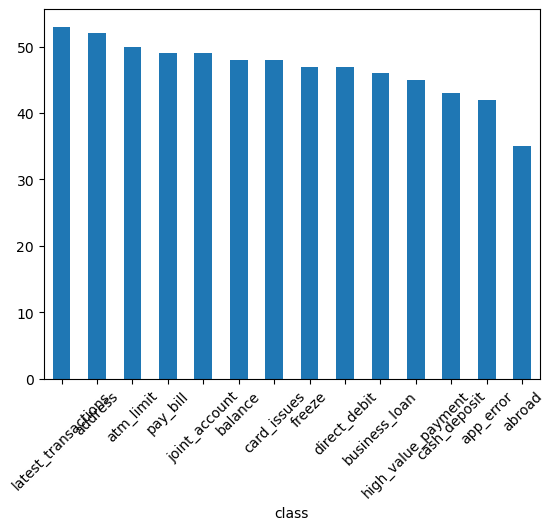

In [21]:
import matplotlib.pyplot as plt

df["class"].value_counts().plot(kind="bar")
# rotate x-axis labels
plt.xticks(rotation=45)

## Preprocessing (using pytorch/torchaudio)

![](https://tiensu.github.io/images/post/audio_preprocessing_flow.png)

In [22]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio

class AudioUtil():
    
    """ Load audio file into tensor
    Returns:
        (tensor, sample_rate): Return signal as a tensor and sample rate
    """
    @staticmethod
    def open(audio_file):
        sig, sr = torchaudio.load(audio_file)
        return (sig, sr)
    
    """
    Convert the given audio to the desired number of channels
    """
    @staticmethod
    def rechannel(audio, new_channel):
        sig, sr = audio
        
        if (sig.shape[0] == new_channel):
            # Nothing to do
            return audio
        
        if (new_channel == 1):
            # Convert from stereo to mono by selecting only the first channel
            resig = sig[:1, :]
        else:
            # Convert from mono to stereo by duplicating the first channel
            resig = torch.cat([sig, sig])
        
        return ((resig, sr))
    
    
    """Since Resample applies to a single channel, we resample one channel at a time"""
    @staticmethod
    def resample(audio, newsr):
        sig, sr = audio

        if (sr == newsr):
            # Nothing to do
            return audio

        num_channels = sig.shape[0]
        # Resample first channel
        resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
        if (num_channels > 1):
            # Resample the second channel and merge both channels
            retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
            resig = torch.cat([resig, retwo])

        return ((resig, newsr))
        
    """Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds"""
    @staticmethod
    def pad_trunc(audio, max_ms):
        sig, sr = audio
        num_rows, sig_len = sig.shape
        max_len = sr//1000 * max_ms

        if (sig_len > max_len):
            # Truncate the signal to the given length
            sig = sig[:,:max_len]

        elif (sig_len < max_len):
            # Length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len

            # Pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))

            sig = torch.cat((pad_begin, sig, pad_end), 1)
        
        return (sig, sr)
    
    # ----------------------------
    # Shifts the signal to the left or right by some percent. Values at the end
    # are 'wrapped around' to the start of the transformed signal.
    # ----------------------------
    @staticmethod
    def time_shift(audio, shift_limit):
        sig,sr = audio
        _, sig_len = sig.shape
        shift_amt = int(random.random() * shift_limit * sig_len)
        return (sig.roll(shift_amt), sr)
    
    
    # ----------------------------
    # Generate a Spectrogram
    # ----------------------------
    @staticmethod
    def spectro_gram(audio, n_mels=64, n_fft=1024, hop_len=None):
        sig,sr = audio
        top_db = 80

        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

        # Convert to decibels
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        return (spec)
    
    # ----------------------------
    # Augment the Spectrogram by masking out some sections of it in both the frequency
    # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
    # overfitting and to help the model generalise better. The masked sections are
    # replaced with the mean value.
    # ----------------------------
    @staticmethod
    def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_mask_param = max_mask_pct * n_mels
        for _ in range(n_freq_masks):
            aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

        time_mask_param = max_mask_pct * n_steps
        for _ in range(n_time_masks):
            aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

        return aug_spec

## Dataset and Dataloader pytorch

In [25]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

# ----------------------------
# Sound Dataset
# ----------------------------
class SoundDS(Dataset):
    def __init__(self, df):
        self.df = df
        self.duration = 4000 # ms
        self.sr = 16_000 # sample rate
        self.channel = 2
        self.shift_pct = 0.4
            
    # ----------------------------
    # Number of items in dataset
    # ----------------------------
    def __len__(self):
        return len(self.df)    
        
    # ----------------------------
    # Get i'th item in dataset
    # ----------------------------
    def __getitem__(self, idx):
        # Get the Class ID
        class_id = self.df.loc[idx, 'intent_class']
        audio_path = self.df.loc[idx, 'path']

        aud = AudioUtil.open(audio_path)
        # Some sounds have a higher sample rate, or fewer channels compared to the
        # majority. So make all sounds have the same number of channels and same 
        # sample rate. Unless the sample rate is the same, the pad_trunc will still
        # result in arrays of different lengths, even though the sound duration is
        # the same.
        reaud = AudioUtil.resample(aud, self.sr)
        rechan = AudioUtil.rechannel(reaud, self.channel)

        dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
        shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
        sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
        aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

        return aug_sgram, class_id

In [26]:
from torch.utils.data import random_split

myds = SoundDS(df)

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)

ValueError: For X (3) and Y (17) with flat shading, A should have shape (16, 2, 3) or (16, 2, 4) or (16, 2) or (32,), not (258048,)

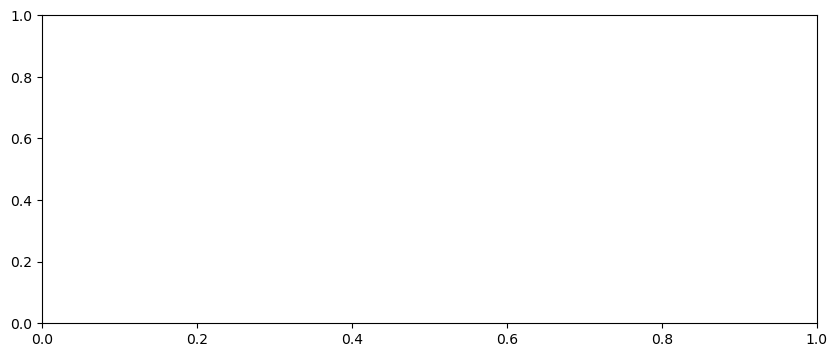

In [34]:
# get random sample in train_dl and display
aug_sgram, class_id = next(iter(train_dl))

# visualize spectrogram
import numpy as np
import librosa.display
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
mel_sgram = librosa.amplitude_to_db(aug_sgram, ref=np.min)
librosa.display.specshow(mel_sgram, y_axis='mel', x_axis='time', sr=16000,)